이 코드는 암호화폐 데이터를 기반으로 딥러닝 모델을 구축, 학습, 평가하는 전체 파이프라인을 구현한 Python 스크립트입니다. 주요 기능은 데이터 로드, 전처리, 기술적 지표 생성, 하이브리드 모델 구축(CNN+LSTM+Attention), 학습 및 평가로 구성됩니다. 아래에 각 부분을 자세히 설명합니다.


---
## **1. 라이브러리 및 초기 설정**
- **필요한 라이브러리 임포트**: 데이터 처리(`pandas`, `numpy`), 시각화(`matplotlib`, `seaborn`), 딥러닝(`tensorflow.keras`), 기술적 지표(`pandas_ta`), 업비트 API(`pyupbit`) 등 다양한 라이브러리를 사용합니다.
- **GPU 설정**: `setup_gpu()` 함수는 GPU 메모리 동적 할당을 활성화하고, 사용 가능한 GPU를 확인합니다.
- **폰트 설정**: 운영 체제에 따라 한글 폰트를 설정하여 그래프에서 한글이 깨지지 않도록 합니다.
- **디렉토리 생성**: 결과 저장을 위해 `results`, `data`, `models`, `logs` 디렉토리를 자동으로 생성합니다.

In [1]:
%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta

import pyupbit
import logging
import gc
from datetime import datetime

#import matplotlib
#matplotlib.use('Agg')  # GUI 없이 이미지 파일로 저장하기 위한 백엔드 설정


In [2]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, \
    roc_curve, precision_recall_curve, det_curve, DetCurveDisplay, auc
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Conv1D, Dropout, BatchNormalization,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Concatenate, Bidirectional
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 경고 메시지 및 GPU 설정
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Display physical divices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def setup_logger(symbol, interval, year, sequence_length, model_type, threshold):
    """로깅 설정"""
    # logs 디렉토리 생성
    if not os.path.exists('logs'):
        os.makedirs('logs')
    
    # 현재 시간을 파일명에 포함
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_filename = f'logs/{symbol}_{interval}_{year}y_{sequence_length}seq_{model_type}_{threshold}_{current_time}.log'
    
    # 로거 설정
    logger = logging.getLogger('crypto_trader')
    logger.setLevel(logging.INFO)
    
    # 파일 핸들러
    file_handler = logging.FileHandler(log_filename, encoding='utf-8')
    file_handler.setLevel(logging.INFO)
    
    # 콘솔 핸들러
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    
    # 포맷터
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    
    # 핸들러 추가
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

def setup_gpu():
    """GPU 설정 및 메모리 할당"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logger.info(f'사용 가능한 GPU: {len(gpus)}개')
        except RuntimeError as e:
            logger.error(e)
    else:
        logger.warning('사용 가능한 GPU가 없습니다.')

    if "CUDA_VISIBLE_DEVICES" in os.environ:
        del os.environ["CUDA_VISIBLE_DEVICES"]

def setup_font():
    """폰트 설정"""
    import platform
    system_name = platform.system()
    if system_name == "Darwin":
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    
    plt.rc("font", family=font_family)
    plt.rc('axes', unicode_minus=False)

def create_directories():
    """필요한 디렉토리 생성"""
    directories = ['results', 'data', 'models', 'logs']
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)


---
## **2. 데이터 로드 및 전처리**
### **CryptoDataLoader 클래스**
- 암호화폐 데이터를 업비트 API를 통해 다운로드하거나 로컬 파일에서 불러옵니다.
- **`calculate_count()`**: 주어진 시간 간격(interval)과 기간(year)에 따라 필요한 데이터 포인트 수를 계산합니다.
- **`download_data()`**: 업비트 API를 통해 OHLCV(Open, High, Low, Close, Volume) 데이터를 다운로드합니다.
- **`load_data()`**: 데이터를 로컬에서 불러오거나 다운로드 후 저장합니다.


In [4]:
class CryptoDataLoader:
    def __init__(self, symbol, interval, year):
        self.symbol = symbol
        self.interval = interval
        self.year = year
        self.file_path = os.path.join('./data', 
            f"{symbol.replace('-', '_')}_{interval}_{year}years.csv")

    def calculate_count(self):
        """데이터 포인트 수 계산"""
        minutes_in_year = 365 * 24 * 60
        interval_minutes = {
            'minute60': 60, 'minute30': 30, 'minute15': 15,
            'minute10': 10, 'minute5': 5, 'minute3': 3, 'minute1': 1,
            'day': 60 * 24, 'week': 60 * 24 * 7, 'month': 60 * 24 * 30
        }
        
        if self.interval not in interval_minutes:
            raise ValueError('지원되지 않는 interval입니다')
        
        return (minutes_in_year // interval_minutes[self.interval]) * self.year

    def download_data(self):
        """업비트에서 데이터 다운로드"""
        count = self.calculate_count()
        df = pyupbit.get_ohlcv(self.symbol, interval=self.interval, 
                              count=count, to=datetime.now())
        
        if df is None or df.empty:
            print(f"데이터를 가져오는 데 실패했습니다. ticker: {self.symbol}")
            return None
        
        return df

    def load_data(self):
        """데이터 로드 또는 다운로드"""
        if os.path.exists(self.file_path):
            logger.info(f"저장된 데이터를 불러옵니다: {self.file_path}")
            df = pd.read_csv(self.file_path, index_col=0, parse_dates=True)
        else:
            logger.info(f"새로운 데이터를 다운로드합니다...")
            df = self.download_data()
            if df is not None:
                df.to_csv(self.file_path)
                logger.info(f"데이터가 저장되었습니다: {self.file_path}")
        
        return df


---
## **3. 데이터 전처리**
### **DataPreprocessor 클래스**
- 시퀀스 데이터를 생성하고 표준화(Scaling)를 수행합니다.
- 데이터를 훈련(train), 검증(validation), 테스트(test) 세트로 분할합니다.




In [ ]:
class DataPreprocessor:
    def __init__(self, sequence_length):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()

    def create_sequences(self, X, y):
        """시퀀스 데이터 생성"""
        sequences = []
        targets = []
        
        for i in range(len(X) - self.sequence_length):
            sequences.append(X[i:(i + self.sequence_length)])
            targets.append(y[i + self.sequence_length - 1])   # -1  added by Pinjoy
            
        return np.array(sequences), np.array(targets)

    def prepare_data(self, features, target):
        """데이터 전처리 및 분할"""
        scaled_features = self.scaler.fit_transform(features)
        X_seq, y_seq = self.create_sequences(scaled_features, target)
        
        # 데이터 분할
        train_size = int(0.7 * len(X_seq))
        val_size = int(0.15 * len(X_seq))
        
        X_train = X_seq[:train_size]
        y_train = y_seq[:train_size]
        
        X_val = X_seq[train_size:train_size+val_size]
        y_val = y_seq[train_size:train_size+val_size]
        
        X_test = X_seq[train_size+val_size:]
        y_test = y_seq[train_size+val_size:]
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)


---
## **4. 기술적 지표 생성**
### **FeatureEngineering 클래스**
- 암호화폐 데이터에서 다양한 기술적 지표를 생성합니다.
  - 이동평균선(MA), 상대강도지수(RSI), 모멘텀(ROC, MOM), MACD, 볼린저 밴드(BB), 거래량 지표(OBV 등) 등을 포함합니다.
  - `pandas_ta` 라이브러리를 활용하여 계산된 지표를 데이터프레임에 추가합니다.



In [6]:
class FeatureEngineering:
    @staticmethod
    def create_features(data):
        """기술적 지표 생성"""
        df = data.copy()
        
        # 기본 특성
        df['return'] = df['close'].pct_change()
        df['volume_change'] = df['volume'].pct_change()
        
        # 이동평균선
        for window in [5, 10, 20, 60]:
            df[f'MA{window}'] = df['close'].rolling(window=window).mean()
        
        # 기술적 지표
        df['MOM'] = ta.mom(df['close'], length=10) # Momentum: mom (Momentum)
        df['ROC'] = ta.roc(df['close'], length=10) # Rate of Change: roc (Momentum) 
        df['RSI'] = ta.rsi(df['close'], length=14) # Relative Strength Index: rsi (Momentum)
        
        # MACD 
        macd = ta.macd(df['close']) # Moving Average Convergence Divergence: macd (Momentum)
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_Signal'] = macd['MACDs_12_26_9']
        df['MACD_Hist'] = macd['MACDh_12_26_9']
        
        # 볼린저 밴드
        bbands = ta.bbands(df['close']) # Bollinger Bands: bbands (Volatility)
        df['BB_Upper'] = bbands['BBU_5_2.0']
        df['BB_Middle'] = bbands['BBM_5_2.0']
        df['BB_Lower'] = bbands['BBL_5_2.0']
        
        # 거래량 지표
        df['Volume_MA5'] = df['volume'].rolling(window=5).mean()
        df['Volume_MA20'] = df['volume'].rolling(window=20).mean()
        df['Volume_ROC'] = ta.roc(df['volume'], length=10) # Rate of Change: roc (Momentum)
        df['OBV'] = ta.obv(df['close'], df['volume']) # On-Balance Volume: obv (Volume)
        
        # 추가 지표
        df['ATR'] = ta.atr(df['high'], df['low'], df['close']) # Average True Range: atr (Volatility)
        df['CCI'] = ta.cci(df['high'], df['low'], df['close']) # Commodity Channel Index: cci (Momentum)
        stoch = ta.stoch(df['high'], df['low'], df['close']) # Stochastic Oscillator: stoch (Momentum)
        df['Stoch_K'] = stoch['STOCHk_14_3_3']
        df['Stoch_D'] = stoch['STOCHd_14_3_3']
        df['ADX'] = ta.adx(df['high'], df['low'], df['close'])['ADX_14'] # Average Directional Movement Index: adx (Trend)
        
        return df.dropna()


---
## **5. 딥러닝 모델 구축**
### **ModelBuilder 클래스**
- 하이브리드 모델(CNN + LSTM + Attention)을 구축합니다.
  - 입력 데이터는 시퀀스 형태로 처리됩니다.
  - CNN 레이어: 지역적인 패턴을 학습하기 위해 1D 컨볼루션 레이어를 사용합니다.
  - LSTM 레이어: 시계열 데이터를 처리하기 위해 양방향 LSTM 레이어를 사용합니다.
  - Multi-head Attention: 중요한 패턴에 가중치를 부여하여 특성을 추출합니다.
  - Dense 레이어: 최종 예측을 위한 완전 연결 레이어입니다.



In [7]:
class ModelBuilder:
    def __init__(self, sequence_length, n_features):
        self.sequence_length = sequence_length
        self.n_features = n_features

    def build_hybrid_model(self):
        """하이브리드 모델 구축"""
        inputs = Input(shape=(self.sequence_length, self.n_features))
        
        # CNN 브랜치
        conv1 = Conv1D(64, 3, padding='same', activation='relu')(inputs)
        conv2 = Conv1D(128, 5, padding='same', activation='relu')(conv1)
        
        # LSTM 브랜치
        lstm1 = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
        
        # 브랜치 결합
        combined = Concatenate()([conv2, lstm2])
        
        # Attention 메커니즘
        attention = MultiHeadAttention(
            num_heads=8, key_dim=32, dropout=0.1
        )(combined, combined, combined)
        
        # Skip connection
        x = attention + combined
        x = LayerNormalization(epsilon=1e-6)(x)
        
        # 특성 추출
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        pooled = Concatenate()([avg_pool, max_pool])
        
        # Dense 레이어
        x = Dense(256, activation='gelu')(pooled)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Dense(128, activation='gelu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        x = Dense(64, activation='gelu')(x)
        x = BatchNormalization()(x)
        
        outputs = Dense(1, activation='sigmoid',
                       bias_initializer=tf.keras.initializers.Constant(1.0))(x)
        
        return Model(inputs=inputs, outputs=outputs)


---
## **6. 모델 학습 및 평가**
### **ModelTrainer 클래스**
- 손실 함수로 Focal Loss를 정의하여 불균형 데이터 문제를 해결합니다.
- 학습 중 성능 향상을 위해 다음과 같은 콜백을 사용합니다:
  - EarlyStopping: 검증 손실이 개선되지 않으면 학습을 중단하고 최적의 가중치를 복원합니다.
  - ReduceLROnPlateau: 학습률을 동적으로 조정하여 과적합을 방지합니다.



In [8]:
class ModelTrainer:
    @staticmethod
    def focal_loss(gamma=2., alpha=.75):
        def loss(y_true, y_pred):
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
            
            batch_size = tf.shape(y_true)[0]
            time_weights = 1 + tf.range(batch_size, dtype=tf.float32) / tf.cast(batch_size, tf.float32)
            time_weights = tf.reshape(time_weights, [-1, 1])
            
            focal_loss = -(
                alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-7) +
                (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-7)
            )
            
            return tf.reduce_mean(focal_loss * time_weights)
        return loss

    @staticmethod
    def get_callbacks():
        """콜백 정의"""
        class LoggingCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                logger.info(
                    f'에포크 {epoch+1} - '
                    f'loss: {logs["loss"]:.4f}, '
                    f'accuracy: {logs["accuracy"]:.4f}, '
                    f'val_loss: {logs["val_loss"]:.4f}, '
                    f'val_accuracy: {logs["val_accuracy"]:.4f}'
                )        
        return [
            LoggingCallback(),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            )
        ]

    @staticmethod
    def calculate_class_weights(y_train):
        """클래스 가중치 계산"""
        total = len(y_train)
        neg_count = np.sum(y_train == 0)
        pos_count = np.sum(y_train == 1)
        pos_weight = (total / (2.0 * pos_count))
        neg_weight = (total / (2.0 * neg_count))
        
        return {0: neg_weight, 1: pos_weight}


### **ModelEvaluator 클래스**
- 학습된 모델의 성능을 평가하고 결과를 시각화합니다:
  - 혼동 행렬(confusion matrix)
  - ROC 커브 및 AUC
  - 학습 과정(정확도 및 손실 변화)



In [9]:
class ModelEvaluator:
    def __init__(self, symbol, interval, year, sequence_length, model_type, threshold):
        self.symbol = symbol
        self.interval = interval
        self.year = year
        self.sequence_length = sequence_length
        self.model_type = model_type
        self.threshold = threshold
        #plt.switch_backend('Agg')

    def evaluate_model(self, model, X_test, y_test):
        """모델 평가 및 결과 출력"""
        # 예측 수행
        y_pred = model.predict(X_test)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # 분류 보고서 출력
        logger.info("\n=== 분류 보고서 ===")
        logger.info("\n" + classification_report(y_test, y_pred_classes))
        
        # 혼동 행렬 시각화
        self.plot_confusion_matrix(y_test, y_pred_classes)
        
        # ROC 커브 시각화
        self.plot_roc_curve(y_test, y_pred)

        #Precision-Recall Curve
        self.plot_pr_curve(y_test, y_pred)

        #DET Curve
        self.plot_det_curve(y_test, y_pred)
        
        return y_pred

    def plot_training_history(self, history):
        """학습 과정 시각화"""
        # matplotlib 버전 차이로 인한 Stack 관련 에러 수정
        #plt.clf()  # 이전 그래프 지우기
        plt.figure(figsize=(8, 8))
        
        # 정확도 그래프
        plt.subplot(2, 1, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy : {self.symbol} ({self.interval}, {self.year} years, seq_len:{self.sequence_length}, {self.model_type}, threshold:{self.threshold})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # 손실 그래프
        plt.subplot(2, 1, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss : {self.symbol} ({self.interval}, {self.year} years, seq_len:{self.sequence_length}, {self.model_type}, threshold:{self.threshold})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'results/{self.symbol}_{self.interval}_{self.year}y_seq{self.sequence_length}_{self.model_type}_th{self.threshold}_accuracy_loss.png')
        plt.show()  # 메모리 해제를 위해 figure 닫기

    def plot_confusion_matrix(self, y_test, y_pred_classes):
        """혼동 행렬 시각화"""
        #plt.clf()  # 이전 그래프 지우기
        cm = confusion_matrix(y_test, y_pred_classes)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {self.symbol} ({self.interval}, {self.year} years, seq_len:{self.sequence_length}, {self.model_type}, threshold:{self.threshold})')
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.axis('equal')    
        
        plt.savefig(f'results/{self.symbol}_{self.interval}_{self.year}y_seq{self.sequence_length}_{self.model_type}_th{self.threshold}_confusion_matrix.png')
        plt.show()  # 메모리 해제를 위해 figure 닫기

    def plot_roc_curve(self, y_test, y_pred):
        """ROC 커브 시각화"""
        #plt.clf()  # 이전 그래프 지우기
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {self.symbol} ({self.interval}, {self.year}years)')
        plt.legend(loc='lower right')
        plt.axis('equal')
        
        plt.savefig(f'results/{self.symbol}_{self.interval}_{self.year}y_seq{self.sequence_length}_{self.model_type}_th{self.threshold}_roc_curve.png')
        plt.show()  # 메모리 해제를 위해 figure 닫기

    def plot_pr_curve(self, y_test, y_pred):
        """PR 커브 시각화"""
        #plt.clf()  # 이전 그래프 지우기
        # Calculate precision and recall values
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        ap_score = auc(recall, precision)
        # Plot precision-recall curve
        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [1, 0], 'k--')
        plt.plot(recall, precision, marker='.', label=f'PR curve (area = {ap_score:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {self.symbol} ({self.interval}, {self.year}years)')
        plt.legend(loc='upper right')
        plt.axis('equal')

        plt.savefig(f'results/{self.symbol}_{self.interval}_{self.year}y_seq{self.sequence_length}_{self.model_type}_th{self.threshold}_pr_curve.png')
        plt.show()  # 메모리 해제를 위해 figure 닫기

    def plot_det_curve(self, y_test, y_pred):
        """Detection Error Tradeoff (DET) curve 시각화"""
        #plt.clf()  # 이전 그래프 지우기
        # Calculate DET values
        fpr, fnr, thresholds = det_curve(y_test, y_pred)
        # Plot DET curve
        plt.figure(figsize=(6, 6))
        DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name=None).plot()

        plt.title(f'Detection Error Tradeoff (DET) curve - {self.symbol} ({self.interval}, {self.year}years)')
        plt.axis('equal')

        plt.savefig(f'results/{self.symbol}_{self.interval}_{self.year}y_seq{self.sequence_length}_{self.model_type}_th{self.threshold}_det_curve.png')
        plt.show()  # 메모리 해제를 위해 figure 닫기


---
## **7. 메인 함수 (`main`)**
- 환경 변수에서 설정값(심볼, 인터벌, 기간 등)을 가져옵니다.
- 전체 워크플로우는 다음 순서로 실행됩니다:
  1. 초기 설정 (로그 및 GPU 설정)
  2. 데이터 로드 및 전처리
  3. 기술적 지표 생성
  4. 딥러닝 모델 구축
  5. 모델 학습
  6. 성능 평가 및 결과 저장
  7. 모델 파일 저장


In [10]:
#def main():
symbol = os.environ.get('CRYPTO_SYMBOL', 'KRW-XRP')
interval = os.environ.get('CRYPTO_INTERVAL', 'minute60')
year = int(os.environ.get('CRYPTO_YEAR', '5'))
sequence_length = int(os.environ.get('CRYPTO_SEQ_LEN', '48'))
model_type = os.environ.get('CRYPTO_MODEL_TYPE', 'up')
threshold = float(os.environ.get('CRYPTO_THRESHOLD', '0.005'))



In [11]:
# 로거 설정
global logger

logger = setup_logger(symbol, interval, year, sequence_length, model_type, threshold)

# 초기 설정
logger.info("=== 학습 시작 ===")
logger.info(f"선택된 심볼: {symbol}")
logger.info(f"인터벌: {interval}")
logger.info(f"기간: {year}년")
logger.info(f"시퀀스 길이: {sequence_length}")
logger.info(f"예측 유형: {model_type}")
if model_type == 'up':
    logger.info(f"상승 임계값: {threshold}")
else:
    logger.info(f"하락 임계값: {threshold}")   

setup_gpu()
setup_font()
create_directories()

2025-03-21 17:20:51,094 - INFO - === 학습 시작 ===
2025-03-21 17:20:51,096 - INFO - 선택된 심볼: KRW-XRP
2025-03-21 17:20:51,097 - INFO - 인터벌: minute60
2025-03-21 17:20:51,099 - INFO - 기간: 5년
2025-03-21 17:20:51,101 - INFO - 시퀀스 길이: 48
2025-03-21 17:20:51,102 - INFO - 예측 유형: up
2025-03-21 17:20:51,104 - INFO - 상승 임계값: 0.005
2025-03-21 17:20:51,105 - INFO - 사용 가능한 GPU: 1개


In [12]:
# 데이터 로드
data_loader = CryptoDataLoader(symbol, interval, year)
df = data_loader.load_data()

2025-03-21 17:20:51,123 - INFO - 저장된 데이터를 불러옵니다: ./data\KRW_XRP_minute60_5years.csv


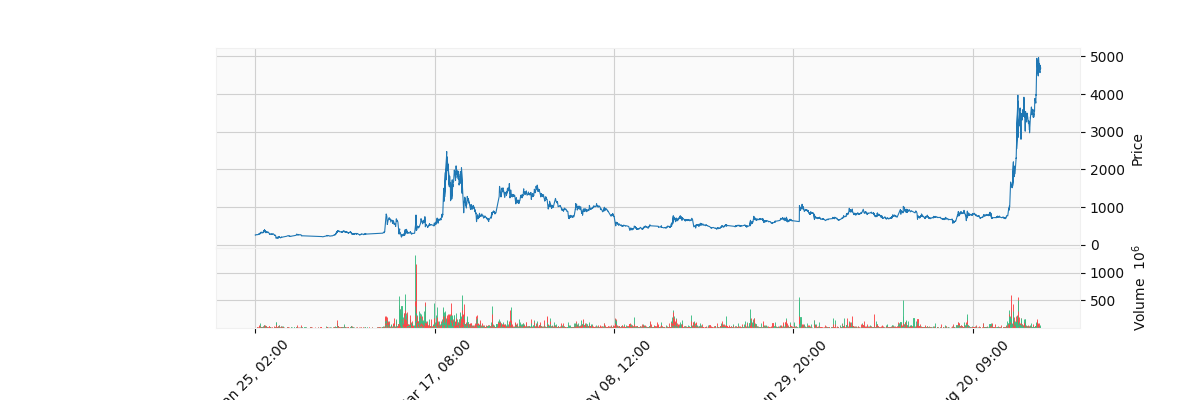

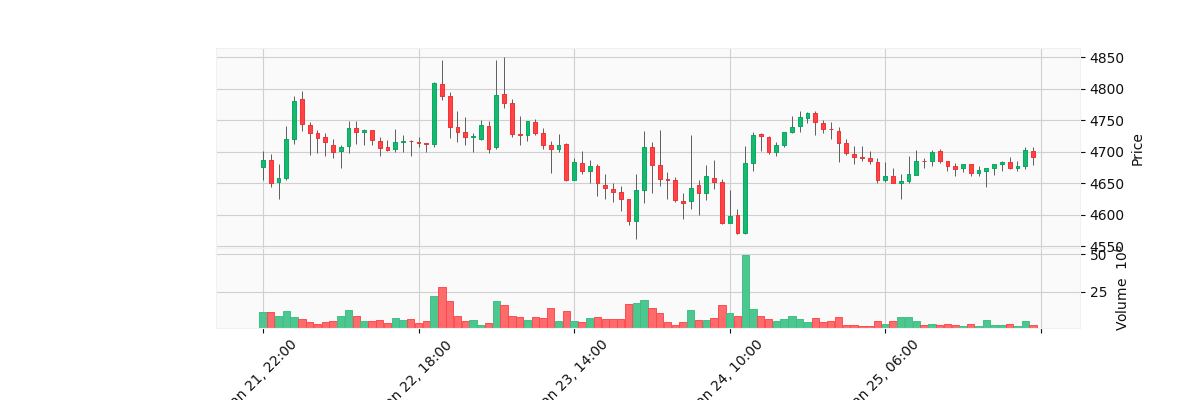

In [14]:
import mplfinance as mpf

mpf.plot(df, type='line', volume=True, style = 'yahoo', figsize=(12,4))
mpf.plot(df.iloc[-100:], type='candle', volume=True, style = 'yahoo', figsize=(12,4))


In [15]:
#if df is not None:
# 특성 엔지니어링
data = FeatureEngineering.create_features(df)

# 특성과 타겟 준비
features = data[[
    'volume_change', 'return',
    'MA5', 'MA10', 'MA20', 'MA60',
    'RSI', 'ROC', 'MOM',
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'BB_Upper', 'BB_Middle', 'BB_Lower',
    'ATR', 'CCI',
    'OBV', 'Volume_ROC', 'Volume_MA5', 'Volume_MA20',
    'Stoch_K', 'Stoch_D', 'ADX'
]]
if model_type == 'up':
    target = (data['return'].shift(-1) >= threshold).astype(int)#.values
else:
    target = (data['return'].shift(-1) <= threshold).astype(int)#.values

print(f"feature: {type(features)} {features.shape}")
print(f"target: {type(target)} {target.shape}")

features

feature: <class 'pandas.core.frame.DataFrame'> (43741, 24)
target: <class 'pandas.core.series.Series'> (43741,)


,volume_change,return,MA5,MA10,MA20,MA60,RSI,ROC,MOM,MACD,...,BB_Lower,ATR,CCI,OBV,Volume_ROC,Volume_MA5,Volume_MA20,Stoch_K,Stoch_D,ADX
2020-01-27 13:00:00,-0.240260,-0.003774,265.6,264.7,262.65,258.550000,60.444125,0.380228,1.0,1.972798,...,263.560392,2.390454,33.971903,1.111865e+07,198.034349,5.729835e+06,2.788947e+06,60.000000,66.666667,64.416345
2020-01-27 14:00:00,-0.655272,0.003788,265.2,264.9,262.95,258.666667,64.265479,0.760456,2.0,1.896145,...,263.703337,2.362233,36.815920,1.223033e+07,175.689346,4.300894e+06,2.754701e+06,56.666667,61.111111,63.788767
2020-01-27 15:00:00,0.335419,0.000000,265.0,265.1,263.25,258.766667,64.265479,0.760456,2.0,1.814480,...,263.735089,2.336075,-3.636364,1.223033e+07,76.340085,3.604072e+06,2.722420e+06,55.185185,57.283951,61.899940
2020-01-27 16:00:00,-0.187279,-0.003774,264.6,265.2,263.45,258.850000,57.790584,0.380228,1.0,1.650048,...,263.620204,2.239667,-12.244898,1.102380e+07,217.006940,2.254434e+06,2.764747e+06,48.042328,53.298060,60.153652
2020-01-27 17:00:00,1.388542,-0.003788,264.2,265.2,263.60,258.916667,52.133924,0.000000,0.0,1.422644,...,262.703337,2.222386,-55.319149,8.141952e+06,384.212343,1.981883e+06,2.855100e+06,32.804233,45.343915,57.356052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-25 21:00:00,-0.067117,0.000855,4675.0,4679.2,4675.80,4676.116667,50.789133,-0.042680,-2.0,-3.019781,...,4662.225024,27.684694,35.028249,1.096315e+10,-9.802525,3.163358e+06,3.665911e+06,68.776371,63.150492,13.341101
2025-01-25 22:00:00,0.255119,-0.001921,4676.8,4676.7,4675.00,4675.533333,47.786233,-0.531915,-25.0,-3.081347,...,4667.556624,27.064359,24.789410,1.096010e+10,-6.067132,3.162677e+06,3.683684e+06,65.050418,65.705976,13.007668
2025-01-25 23:00:00,-0.367032,0.000428,4678.0,4675.8,4674.35,4675.066667,48.514725,-0.192061,-9.0,-2.934924,...,4670.733639,26.202619,-8.314774,1.096203e+10,-24.427655,3.199584e+06,3.677462e+06,59.922763,64.583184,12.841017
2025-01-26 00:00:00,1.537778,0.005559,4683.8,4678.4,4675.25,4674.933333,56.927971,0.555912,26.0,-0.712684,...,4663.664459,26.902432,148.630137,1.096694e+10,64.687649,2.986824e+06,3.818159e+06,65.716079,63.563087,12.372609


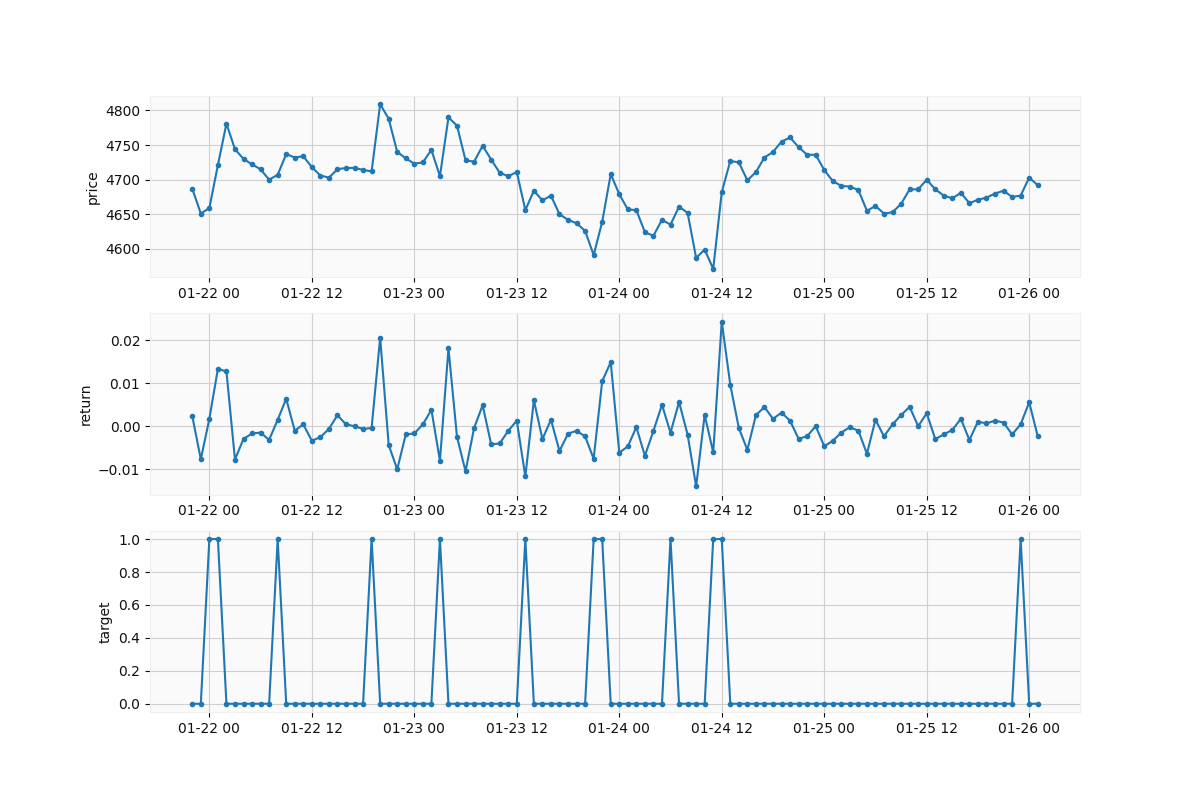

In [16]:
plt.figure(figsize =(12, 8))
plt.subplot(3,1,1)
plt.plot(df.iloc[-100:]['close'], marker ='.')
plt.ylabel("price")
plt.subplot(3,1,2)
plt.plot(data.iloc[-100:]['return'], marker ='.')
plt.ylabel("return")
plt.subplot(3,1,3)
plt.plot(target[-100:], marker ='.')
plt.ylabel("target")
plt.show()

In [17]:
# 데이터 전처리
preprocessor = DataPreprocessor(sequence_length)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    preprocessor.prepare_data(features, target)

print(f"X_train: {type(X_train)} {X_train.shape}")
print(f"y_train: {type(y_train)} {y_train.shape}")

C:\Users\shong\AppData\Local\Temp\ipykernel_930968\3668049301.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets.append(y[i + self.sequence_length -1])   # added -1


X_train: <class 'numpy.ndarray'> (30585, 48, 24)
y_train: <class 'numpy.ndarray'> (30585,)


In [18]:
# 모델 생성
model_builder = ModelBuilder(sequence_length, features.shape[1])
model = model_builder.build_hybrid_model()

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=ModelTrainer.focal_loss(gamma=2., alpha=0.75),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# 모델 학습 fit()
class_weights = ModelTrainer.calculate_class_weights(y_train)
callbacks = ModelTrainer.get_callbacks()

logger.info("=== 모델 학습 시작 ===")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)
logger.info("=== 모델 학습 완료 ===")



2025-03-21 17:22:01,019 - INFO - === 모델 학습 시작 ===


Epoch 1/100
956/956 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.5996 - precision: 0.2453 - recall: 0.5112

2025-03-21 17:23:14,633 - INFO - 에포크 1 - loss: 0.1034, accuracy: 0.5996, val_loss: 0.0712, val_accuracy: 0.7482


956/956 [==============================] - 73s 60ms/step - loss: 0.1034 - accuracy: 0.5996 - precision: 0.2453 - recall: 0.5112 - val_loss: 0.0712 - val_accuracy: 0.7482 - val_precision: 0.1731 - val_recall: 0.3257 - lr: 0.0010
Epoch 2/100
956/956 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.6591 - precision: 0.2815 - recall: 0.4863

2025-03-21 17:24:10,340 - INFO - 에포크 2 - loss: 0.0872, accuracy: 0.6591, val_loss: 0.0654, val_accuracy: 0.7890


956/956 [==============================] - 56s 58ms/step - loss: 0.0872 - accuracy: 0.6591 - precision: 0.2815 - recall: 0.4863 - val_loss: 0.0654 - val_accuracy: 0.7890 - val_precision: 0.2142 - val_recall: 0.3257 - lr: 0.0010
Epoch 3/100
956/956 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.6713 - precision: 0.2968 - recall: 0.5055

2025-03-21 17:25:05,981 - INFO - 에포크 3 - loss: 0.0858, accuracy: 0.6713, val_loss: 0.0671, val_accuracy: 0.7213


956/956 [==============================] - 56s 58ms/step - loss: 0.0858 - accuracy: 0.6713 - precision: 0.2968 - recall: 0.5055 - val_loss: 0.0671 - val_accuracy: 0.7213 - val_precision: 0.2026 - val_recall: 0.5000 - lr: 0.0010
Epoch 4/100
956/956 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.6708 - precision: 0.2986 - recall: 0.5151

2025-03-21 17:26:01,068 - INFO - 에포크 4 - loss: 0.0853, accuracy: 0.6708, val_loss: 0.0639, val_accuracy: 0.7874


956/956 [==============================] - 55s 58ms/step - loss: 0.0853 - accuracy: 0.6708 - precision: 0.2986 - recall: 0.5151 - val_loss: 0.0639 - val_accuracy: 0.7874 - val_precision: 0.2183 - val_recall: 0.3419 - lr: 0.0010
Epoch 5/100
956/956 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.6838 - precision: 0.3091 - recall: 0.5082

2025-03-21 17:26:56,569 - INFO - 에포크 5 - loss: 0.0848, accuracy: 0.6838, val_loss: 0.0653, val_accuracy: 0.7645


956/956 [==============================] - 55s 58ms/step - loss: 0.0848 - accuracy: 0.6838 - precision: 0.3091 - recall: 0.5082 - val_loss: 0.0653 - val_accuracy: 0.7645 - val_precision: 0.2150 - val_recall: 0.4095 - lr: 0.0010
Epoch 6/100
956/956 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.6847 - precision: 0.3103 - recall: 0.5095

2025-03-21 17:27:51,490 - INFO - 에포크 6 - loss: 0.0844, accuracy: 0.6847, val_loss: 0.0659, val_accuracy: 0.7345


956/956 [==============================] - 55s 57ms/step - loss: 0.0844 - accuracy: 0.6847 - precision: 0.3103 - recall: 0.5095 - val_loss: 0.0659 - val_accuracy: 0.7345 - val_precision: 0.2093 - val_recall: 0.4865 - lr: 0.0010
Epoch 7/100
956/956 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.6753 - precision: 0.3059 - recall: 0.5292

2025-03-21 17:28:45,726 - INFO - 에포크 7 - loss: 0.0847, accuracy: 0.6753, val_loss: 0.0651, val_accuracy: 0.7577


956/956 [==============================] - 54s 57ms/step - loss: 0.0847 - accuracy: 0.6753 - precision: 0.3059 - recall: 0.5292 - val_loss: 0.0651 - val_accuracy: 0.7577 - val_precision: 0.2088 - val_recall: 0.4108 - lr: 0.0010
Epoch 8/100
956/956 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.6811 - precision: 0.3004 - recall: 0.4831

2025-03-21 17:29:39,686 - INFO - 에포크 8 - loss: 0.0853, accuracy: 0.6811, val_loss: 0.0644, val_accuracy: 0.8826


956/956 [==============================] - 54s 56ms/step - loss: 0.0853 - accuracy: 0.6811 - precision: 0.3004 - recall: 0.4831 - val_loss: 0.0644 - val_accuracy: 0.8826 - val_precision: 0.2836 - val_recall: 0.0257 - lr: 0.0010
Epoch 9/100
955/956 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.6893 - precision: 0.3122 - recall: 0.4988

2025-03-21 17:30:33,586 - INFO - 에포크 9 - loss: 0.0845, accuracy: 0.6892, val_loss: 0.0676, val_accuracy: 0.7334



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
956/956 [==============================] - 54s 56ms/step - loss: 0.0845 - accuracy: 0.6892 - precision: 0.3121 - recall: 0.4986 - val_loss: 0.0676 - val_accuracy: 0.7334 - val_precision: 0.2005 - val_recall: 0.4554 - lr: 0.0010
Epoch 10/100
956/956 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.6947 - precision: 0.3180 - recall: 0.4996

2025-03-21 17:31:28,898 - INFO - 에포크 10 - loss: 0.0837, accuracy: 0.6947, val_loss: 0.0629, val_accuracy: 0.8021


956/956 [==============================] - 55s 58ms/step - loss: 0.0837 - accuracy: 0.6947 - precision: 0.3180 - recall: 0.4996 - val_loss: 0.0629 - val_accuracy: 0.8021 - val_precision: 0.2414 - val_recall: 0.3514 - lr: 5.0000e-04
Epoch 11/100
956/956 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.6928 - precision: 0.3220 - recall: 0.5262

2025-03-21 17:32:24,628 - INFO - 에포크 11 - loss: 0.0834, accuracy: 0.6928, val_loss: 0.0640, val_accuracy: 0.8190


956/956 [==============================] - 56s 58ms/step - loss: 0.0834 - accuracy: 0.6928 - precision: 0.3220 - recall: 0.5262 - val_loss: 0.0640 - val_accuracy: 0.8190 - val_precision: 0.2549 - val_recall: 0.3135 - lr: 5.0000e-04
Epoch 12/100
956/956 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.6946 - precision: 0.3221 - recall: 0.5179

2025-03-21 17:33:19,876 - INFO - 에포크 12 - loss: 0.0832, accuracy: 0.6946, val_loss: 0.0628, val_accuracy: 0.8430


956/956 [==============================] - 55s 58ms/step - loss: 0.0832 - accuracy: 0.6946 - precision: 0.3221 - recall: 0.5179 - val_loss: 0.0628 - val_accuracy: 0.8430 - val_precision: 0.2773 - val_recall: 0.2432 - lr: 5.0000e-04
Epoch 13/100
956/956 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.6891 - precision: 0.3203 - recall: 0.5356

2025-03-21 17:34:14,058 - INFO - 에포크 13 - loss: 0.0830, accuracy: 0.6891, val_loss: 0.0644, val_accuracy: 0.8097


956/956 [==============================] - 54s 57ms/step - loss: 0.0830 - accuracy: 0.6891 - precision: 0.3203 - recall: 0.5356 - val_loss: 0.0644 - val_accuracy: 0.8097 - val_precision: 0.2546 - val_recall: 0.3554 - lr: 5.0000e-04
Epoch 14/100
955/956 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.6877 - precision: 0.3213 - recall: 0.5464

2025-03-21 17:35:07,750 - INFO - 에포크 14 - loss: 0.0830, accuracy: 0.6876, val_loss: 0.0631, val_accuracy: 0.8102


956/956 [==============================] - 54s 56ms/step - loss: 0.0830 - accuracy: 0.6876 - precision: 0.3212 - recall: 0.5462 - val_loss: 0.0631 - val_accuracy: 0.8102 - val_precision: 0.2520 - val_recall: 0.3459 - lr: 5.0000e-04
Epoch 15/100
956/956 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.6910 - precision: 0.3218 - recall: 0.5337

2025-03-21 17:36:03,338 - INFO - 에포크 15 - loss: 0.0828, accuracy: 0.6910, val_loss: 0.0627, val_accuracy: 0.8216


956/956 [==============================] - 56s 58ms/step - loss: 0.0828 - accuracy: 0.6910 - precision: 0.3218 - recall: 0.5337 - val_loss: 0.0627 - val_accuracy: 0.8216 - val_precision: 0.2614 - val_recall: 0.3176 - lr: 5.0000e-04
Epoch 16/100
956/956 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.6961 - precision: 0.3273 - recall: 0.5351

2025-03-21 17:37:00,986 - INFO - 에포크 16 - loss: 0.0826, accuracy: 0.6961, val_loss: 0.0626, val_accuracy: 0.8007


956/956 [==============================] - 58s 60ms/step - loss: 0.0826 - accuracy: 0.6961 - precision: 0.3273 - recall: 0.5351 - val_loss: 0.0626 - val_accuracy: 0.8007 - val_precision: 0.2450 - val_recall: 0.3676 - lr: 5.0000e-04
Epoch 17/100
956/956 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.6878 - precision: 0.3207 - recall: 0.5430

2025-03-21 17:38:05,690 - INFO - 에포크 17 - loss: 0.0826, accuracy: 0.6878, val_loss: 0.0640, val_accuracy: 0.8582


956/956 [==============================] - 65s 68ms/step - loss: 0.0826 - accuracy: 0.6878 - precision: 0.3207 - recall: 0.5430 - val_loss: 0.0640 - val_accuracy: 0.8582 - val_precision: 0.3002 - val_recall: 0.1919 - lr: 5.0000e-04
Epoch 18/100
956/956 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.6904 - precision: 0.3198 - recall: 0.5268

2025-03-21 17:39:14,004 - INFO - 에포크 18 - loss: 0.0829, accuracy: 0.6904, val_loss: 0.0646, val_accuracy: 0.8518


956/956 [==============================] - 68s 71ms/step - loss: 0.0829 - accuracy: 0.6904 - precision: 0.3198 - recall: 0.5268 - val_loss: 0.0646 - val_accuracy: 0.8518 - val_precision: 0.2792 - val_recall: 0.1973 - lr: 5.0000e-04
Epoch 19/100
956/956 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.6836 - precision: 0.3180 - recall: 0.5496

2025-03-21 17:40:13,325 - INFO - 에포크 19 - loss: 0.0829, accuracy: 0.6836, val_loss: 0.0623, val_accuracy: 0.8163


956/956 [==============================] - 59s 62ms/step - loss: 0.0829 - accuracy: 0.6836 - precision: 0.3180 - recall: 0.5496 - val_loss: 0.0623 - val_accuracy: 0.8163 - val_precision: 0.2553 - val_recall: 0.3270 - lr: 5.0000e-04
Epoch 20/100
956/956 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.6872 - precision: 0.3212 - recall: 0.5479

2025-03-21 17:41:08,802 - INFO - 에포크 20 - loss: 0.0826, accuracy: 0.6872, val_loss: 0.0648, val_accuracy: 0.8410


956/956 [==============================] - 55s 58ms/step - loss: 0.0826 - accuracy: 0.6872 - precision: 0.3212 - recall: 0.5479 - val_loss: 0.0648 - val_accuracy: 0.8410 - val_precision: 0.2670 - val_recall: 0.2338 - lr: 5.0000e-04
Epoch 21/100
956/956 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.6884 - precision: 0.3215 - recall: 0.5440

2025-03-21 17:42:00,407 - INFO - 에포크 21 - loss: 0.0824, accuracy: 0.6884, val_loss: 0.0634, val_accuracy: 0.8430


956/956 [==============================] - 52s 54ms/step - loss: 0.0824 - accuracy: 0.6884 - precision: 0.3215 - recall: 0.5440 - val_loss: 0.0634 - val_accuracy: 0.8430 - val_precision: 0.2859 - val_recall: 0.2608 - lr: 5.0000e-04
Epoch 22/100
956/956 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.6949 - precision: 0.3284 - recall: 0.5457

2025-03-21 17:42:51,929 - INFO - 에포크 22 - loss: 0.0822, accuracy: 0.6949, val_loss: 0.0619, val_accuracy: 0.8706


956/956 [==============================] - 52s 54ms/step - loss: 0.0822 - accuracy: 0.6949 - precision: 0.3284 - recall: 0.5457 - val_loss: 0.0619 - val_accuracy: 0.8706 - val_precision: 0.3483 - val_recall: 0.1676 - lr: 5.0000e-04
Epoch 23/100
956/956 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.6922 - precision: 0.3259 - recall: 0.5472

2025-03-21 17:43:43,043 - INFO - 에포크 23 - loss: 0.0824, accuracy: 0.6922, val_loss: 0.0632, val_accuracy: 0.8100


956/956 [==============================] - 51s 53ms/step - loss: 0.0824 - accuracy: 0.6922 - precision: 0.3259 - recall: 0.5472 - val_loss: 0.0632 - val_accuracy: 0.8100 - val_precision: 0.2502 - val_recall: 0.3419 - lr: 5.0000e-04
Epoch 24/100
956/956 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.6945 - precision: 0.3274 - recall: 0.5432

2025-03-21 17:44:34,084 - INFO - 에포크 24 - loss: 0.0821, accuracy: 0.6945, val_loss: 0.0627, val_accuracy: 0.8108


956/956 [==============================] - 51s 53ms/step - loss: 0.0821 - accuracy: 0.6945 - precision: 0.3274 - recall: 0.5432 - val_loss: 0.0627 - val_accuracy: 0.8108 - val_precision: 0.2563 - val_recall: 0.3554 - lr: 5.0000e-04
Epoch 25/100
955/956 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.6899 - precision: 0.3248 - recall: 0.5533

2025-03-21 17:45:27,020 - INFO - 에포크 25 - loss: 0.0824, accuracy: 0.6899, val_loss: 0.0629, val_accuracy: 0.8071


956/956 [==============================] - 53s 55ms/step - loss: 0.0824 - accuracy: 0.6899 - precision: 0.3249 - recall: 0.5534 - val_loss: 0.0629 - val_accuracy: 0.8071 - val_precision: 0.2495 - val_recall: 0.3527 - lr: 5.0000e-04
Epoch 26/100
956/956 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.6934 - precision: 0.3257 - recall: 0.5403

2025-03-21 17:46:20,983 - INFO - 에포크 26 - loss: 0.0820, accuracy: 0.6934, val_loss: 0.0624, val_accuracy: 0.8123


956/956 [==============================] - 54s 56ms/step - loss: 0.0820 - accuracy: 0.6934 - precision: 0.3257 - recall: 0.5403 - val_loss: 0.0624 - val_accuracy: 0.8123 - val_precision: 0.2515 - val_recall: 0.3351 - lr: 5.0000e-04
Epoch 27/100
956/956 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.6891 - precision: 0.3250 - recall: 0.5575

2025-03-21 17:47:21,833 - INFO - 에포크 27 - loss: 0.0822, accuracy: 0.6891, val_loss: 0.0625, val_accuracy: 0.8393



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
956/956 [==============================] - 61s 64ms/step - loss: 0.0822 - accuracy: 0.6891 - precision: 0.3250 - recall: 0.5575 - val_loss: 0.0625 - val_accuracy: 0.8393 - val_precision: 0.2688 - val_recall: 0.2459 - lr: 5.0000e-04
Epoch 28/100
956/956 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.6974 - precision: 0.3325 - recall: 0.5538

2025-03-21 17:48:17,952 - INFO - 에포크 28 - loss: 0.0812, accuracy: 0.6974, val_loss: 0.0627, val_accuracy: 0.8318


956/956 [==============================] - 56s 59ms/step - loss: 0.0812 - accuracy: 0.6974 - precision: 0.3325 - recall: 0.5538 - val_loss: 0.0627 - val_accuracy: 0.8318 - val_precision: 0.2720 - val_recall: 0.2919 - lr: 2.5000e-04
Epoch 29/100
956/956 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.6886 - precision: 0.3269 - recall: 0.5696

2025-03-21 17:49:13,616 - INFO - 에포크 29 - loss: 0.0816, accuracy: 0.6886, val_loss: 0.0626, val_accuracy: 0.8575


956/956 [==============================] - 56s 58ms/step - loss: 0.0816 - accuracy: 0.6886 - precision: 0.3269 - recall: 0.5696 - val_loss: 0.0626 - val_accuracy: 0.8575 - val_precision: 0.3052 - val_recall: 0.2054 - lr: 2.5000e-04
Epoch 30/100
956/956 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.6980 - precision: 0.3328 - recall: 0.5521

2025-03-21 17:50:09,964 - INFO - 에포크 30 - loss: 0.0813, accuracy: 0.6980, val_loss: 0.0627, val_accuracy: 0.8422


956/956 [==============================] - 56s 59ms/step - loss: 0.0813 - accuracy: 0.6980 - precision: 0.3328 - recall: 0.5521 - val_loss: 0.0627 - val_accuracy: 0.8422 - val_precision: 0.2975 - val_recall: 0.2919 - lr: 2.5000e-04
Epoch 31/100
956/956 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.6888 - precision: 0.3279 - recall: 0.5740

2025-03-21 17:51:11,832 - INFO - 에포크 31 - loss: 0.0811, accuracy: 0.6888, val_loss: 0.0630, val_accuracy: 0.8196


956/956 [==============================] - 62s 65ms/step - loss: 0.0811 - accuracy: 0.6888 - precision: 0.3279 - recall: 0.5740 - val_loss: 0.0630 - val_accuracy: 0.8196 - val_precision: 0.2528 - val_recall: 0.3054 - lr: 2.5000e-04
Epoch 32/100
956/956 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.6967 - precision: 0.3345 - recall: 0.5669

2025-03-21 17:52:10,612 - INFO - 에포크 32 - loss: 0.0812, accuracy: 0.6967, val_loss: 0.0625, val_accuracy: 0.8323



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
956/956 [==============================] - 59s 61ms/step - loss: 0.0812 - accuracy: 0.6967 - precision: 0.3345 - recall: 0.5669 - val_loss: 0.0625 - val_accuracy: 0.8323 - val_precision: 0.2781 - val_recall: 0.3041 - lr: 2.5000e-04
Epoch 33/100
956/956 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.6916 - precision: 0.3324 - recall: 0.5824

2025-03-21 17:53:12,752 - INFO - 에포크 33 - loss: 0.0807, accuracy: 0.6916, val_loss: 0.0630, val_accuracy: 0.8323


956/956 [==============================] - 62s 65ms/step - loss: 0.0807 - accuracy: 0.6916 - precision: 0.3324 - recall: 0.5824 - val_loss: 0.0630 - val_accuracy: 0.8323 - val_precision: 0.2759 - val_recall: 0.2986 - lr: 1.2500e-04
Epoch 34/100
956/956 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.6978 - precision: 0.3357 - recall: 0.5681

2025-03-21 17:54:14,584 - INFO - 에포크 34 - loss: 0.0803, accuracy: 0.6978, val_loss: 0.0631, val_accuracy: 0.8459


956/956 [==============================] - 62s 65ms/step - loss: 0.0803 - accuracy: 0.6978 - precision: 0.3357 - recall: 0.5681 - val_loss: 0.0631 - val_accuracy: 0.8459 - val_precision: 0.2929 - val_recall: 0.2581 - lr: 1.2500e-04
Epoch 35/100
956/956 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.7000 - precision: 0.3377 - recall: 0.5664

2025-03-21 17:55:15,127 - INFO - 에포크 35 - loss: 0.0803, accuracy: 0.7000, val_loss: 0.0636, val_accuracy: 0.8355


956/956 [==============================] - 61s 63ms/step - loss: 0.0803 - accuracy: 0.7000 - precision: 0.3377 - recall: 0.5664 - val_loss: 0.0636 - val_accuracy: 0.8355 - val_precision: 0.2782 - val_recall: 0.2865 - lr: 1.2500e-04
Epoch 36/100
956/956 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.6940 - precision: 0.3349 - recall: 0.5839

2025-03-21 17:56:19,632 - INFO - 에포크 36 - loss: 0.0801, accuracy: 0.6940, val_loss: 0.0636, val_accuracy: 0.8289


956/956 [==============================] - 64s 67ms/step - loss: 0.0801 - accuracy: 0.6940 - precision: 0.3349 - recall: 0.5839 - val_loss: 0.0636 - val_accuracy: 0.8289 - val_precision: 0.2740 - val_recall: 0.3122 - lr: 1.2500e-04
Epoch 37/100
956/956 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.6988 - precision: 0.3398 - recall: 0.5841

2025-03-21 17:57:18,663 - INFO - 에포크 37 - loss: 0.0796, accuracy: 0.6988, val_loss: 0.0636, val_accuracy: 0.8144



Epoch 37: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
956/956 [==============================] - 59s 62ms/step - loss: 0.0796 - accuracy: 0.6988 - precision: 0.3398 - recall: 0.5841 - val_loss: 0.0636 - val_accuracy: 0.8144 - val_precision: 0.2591 - val_recall: 0.3459 - lr: 1.2500e-04
Epoch 38/100
956/956 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.7009 - precision: 0.3403 - recall: 0.5753

2025-03-21 17:58:18,969 - INFO - 에포크 38 - loss: 0.0795, accuracy: 0.7009, val_loss: 0.0635, val_accuracy: 0.8349


956/956 [==============================] - 60s 63ms/step - loss: 0.0795 - accuracy: 0.7009 - precision: 0.3403 - recall: 0.5753 - val_loss: 0.0635 - val_accuracy: 0.8349 - val_precision: 0.2773 - val_recall: 0.2878 - lr: 6.2500e-05
Epoch 39/100
956/956 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.6950 - precision: 0.3387 - recall: 0.5986

2025-03-21 17:59:19,763 - INFO - 에포크 39 - loss: 0.0794, accuracy: 0.6950, val_loss: 0.0633, val_accuracy: 0.8289


956/956 [==============================] - 61s 64ms/step - loss: 0.0794 - accuracy: 0.6950 - precision: 0.3387 - recall: 0.5986 - val_loss: 0.0633 - val_accuracy: 0.8289 - val_precision: 0.2708 - val_recall: 0.3041 - lr: 6.2500e-05
Epoch 40/100
956/956 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.7026 - precision: 0.3426 - recall: 0.5780

2025-03-21 18:00:24,123 - INFO - 에포크 40 - loss: 0.0795, accuracy: 0.7026, val_loss: 0.0634, val_accuracy: 0.8302


956/956 [==============================] - 64s 67ms/step - loss: 0.0795 - accuracy: 0.7026 - precision: 0.3426 - recall: 0.5780 - val_loss: 0.0634 - val_accuracy: 0.8302 - val_precision: 0.2700 - val_recall: 0.2959 - lr: 6.2500e-05
Epoch 41/100
956/956 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.7011 - precision: 0.3414 - recall: 0.5800

2025-03-21 18:01:27,228 - INFO - 에포크 41 - loss: 0.0789, accuracy: 0.7011, val_loss: 0.0637, val_accuracy: 0.8419


956/956 [==============================] - 63s 66ms/step - loss: 0.0789 - accuracy: 0.7011 - precision: 0.3414 - recall: 0.5800 - val_loss: 0.0637 - val_accuracy: 0.8419 - val_precision: 0.2824 - val_recall: 0.2595 - lr: 6.2500e-05
Epoch 42/100
956/956 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.7015 - precision: 0.3437 - recall: 0.5901

2025-03-21 18:02:29,004 - INFO - 에포크 42 - loss: 0.0792, accuracy: 0.7015, val_loss: 0.0639, val_accuracy: 0.8337



Epoch 42: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 22.
956/956 [==============================] - 62s 65ms/step - loss: 0.0792 - accuracy: 0.7015 - precision: 0.3437 - recall: 0.5901 - val_loss: 0.0639 - val_accuracy: 0.8337 - val_precision: 0.2715 - val_recall: 0.2811 - lr: 6.2500e-05
Epoch 42: early stopping


2025-03-21 18:02:29,031 - INFO - === 모델 학습 완료 ===


2025-03-21 18:02:55,904 - INFO - === 모델 평가 시작 ===


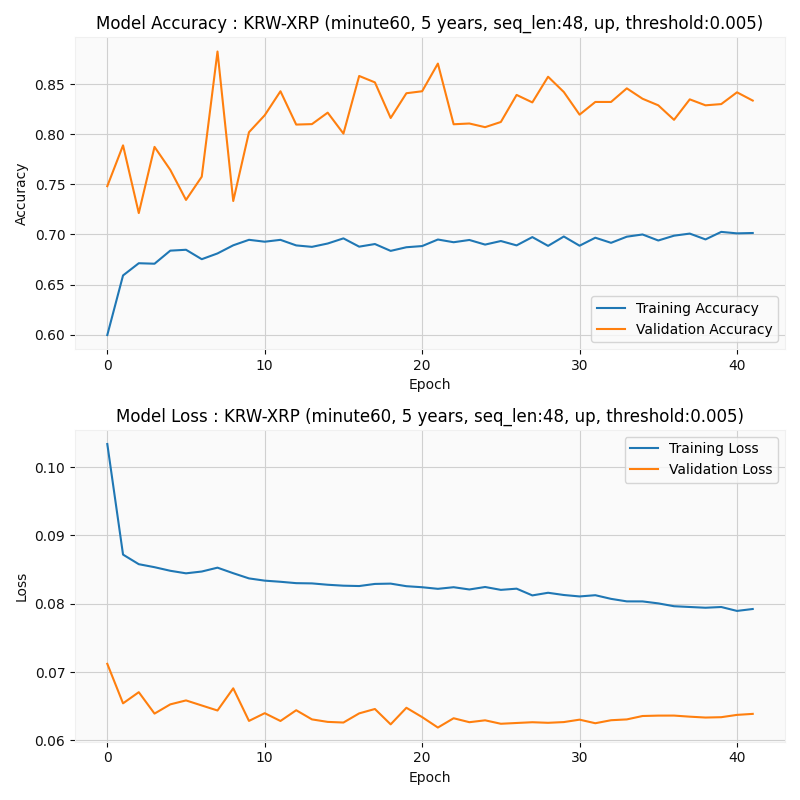

205/205 [==============================] - 7s 22ms/step


2025-03-21 18:03:03,229 - INFO - 
=== 분류 보고서 ===
2025-03-21 18:03:03,245 - INFO - 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5435
           1       0.37      0.38      0.38      1120

    accuracy                           0.79      6555
   macro avg       0.62      0.62      0.62      6555
weighted avg       0.79      0.79      0.79      6555



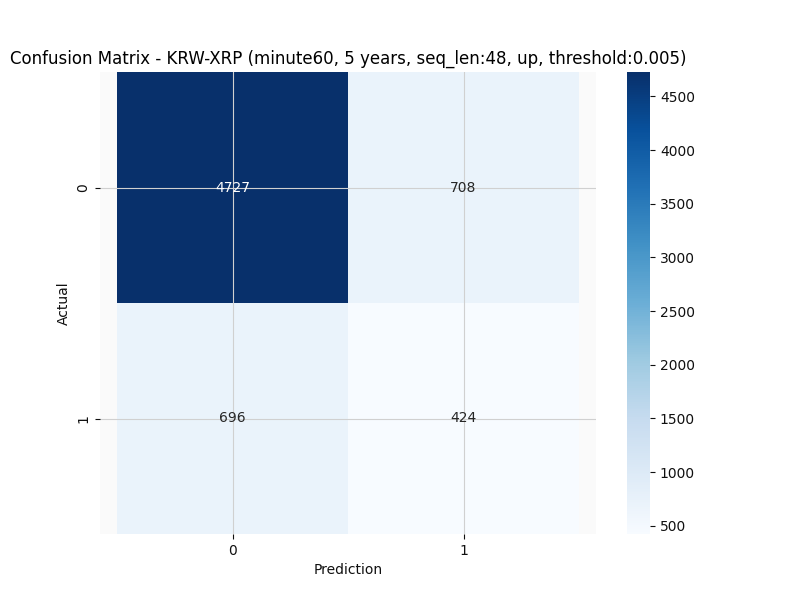

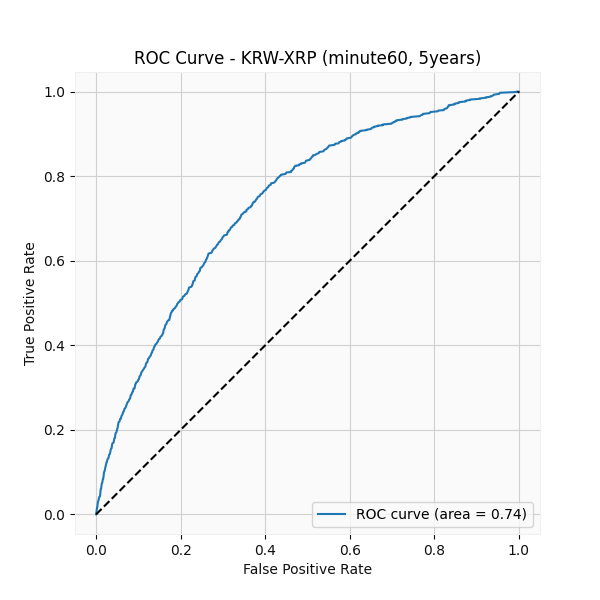

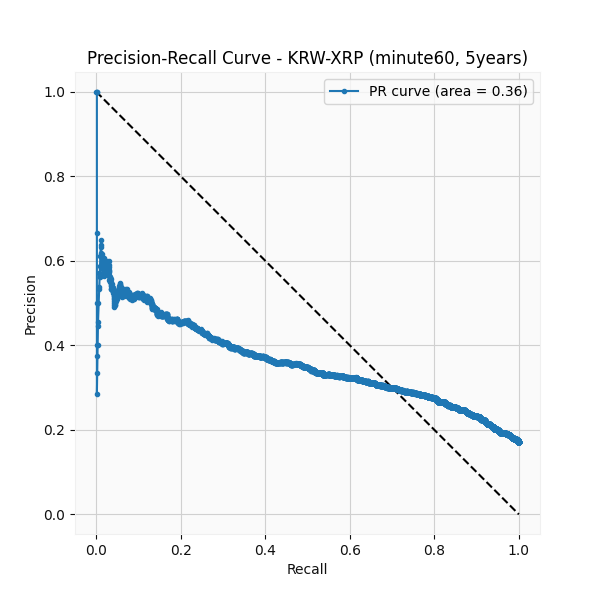

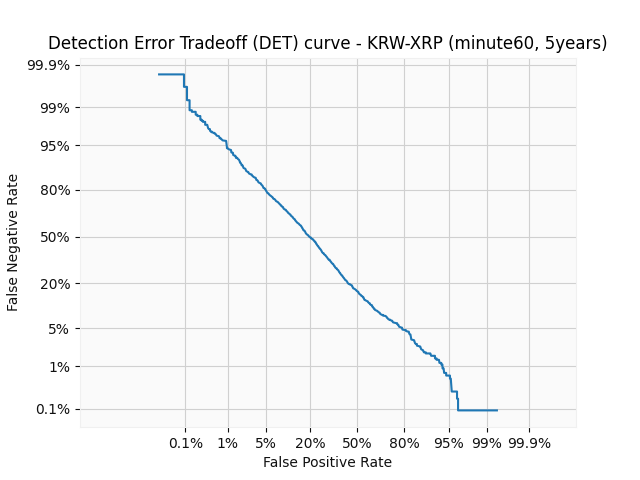

2025-03-21 18:03:04,143 - INFO - === 모델 평가 완료 ===


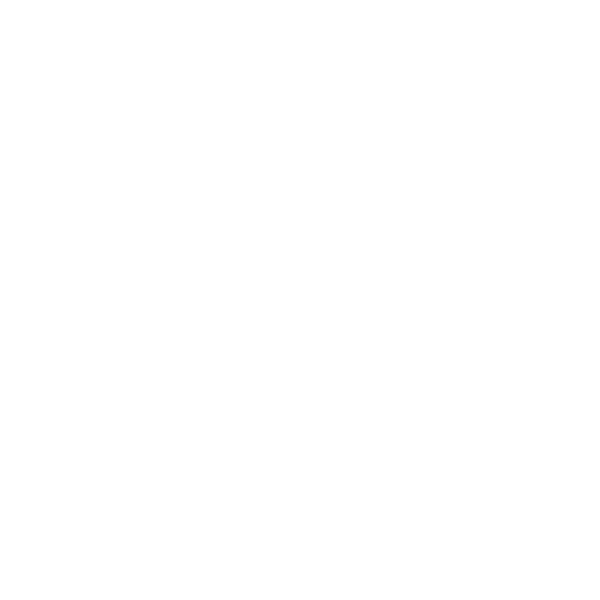

In [19]:
# 모델 평가 predict()
%matplotlib ipympl
logger.info("=== 모델 평가 시작 ===")
evaluator = ModelEvaluator(symbol, interval, year, sequence_length, model_type, threshold)
evaluator.plot_training_history(history)
y_pred = evaluator.evaluate_model(model, X_test, y_test)
logger.info("=== 모델 평가 완료 ===")



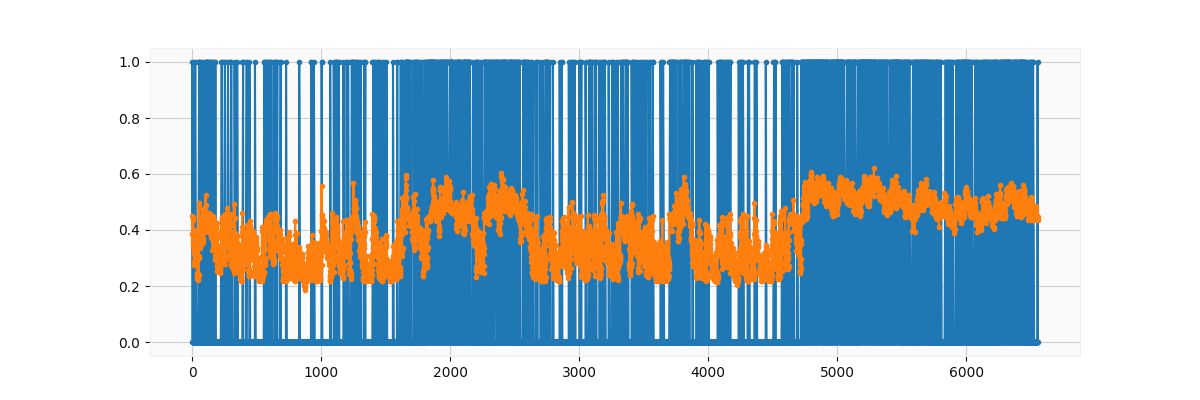

In [20]:
%matplotlib ipympl
plt.figure(figsize =(12, 4))
plt.plot(y_test, marker ='.')
plt.plot(y_pred, marker ='.')
#plt.plot(y_test[-200:], marker ='.')
#plt.plot(y_pred[-200:], marker ='.')
#plt.plot(y_pred[-200:].round(), marker ='.')
plt.show()

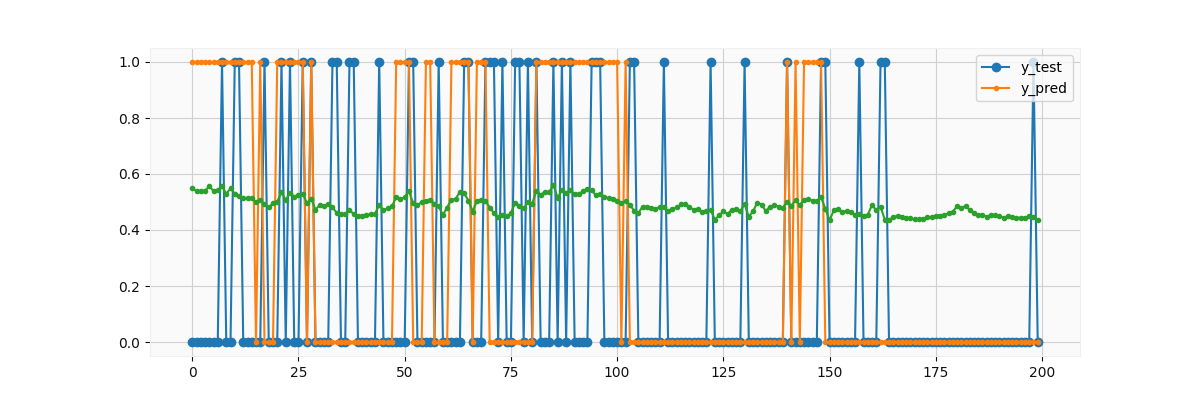

In [21]:
%matplotlib ipympl
plt.figure(figsize =(12, 4))
#plt.subplot(3,1,1)
plt.plot(y_test[-200:], marker ='o', label = 'y_test')
plt.plot(y_pred[-200:].round(), marker ='.', label = 'y_pred')
plt.plot(y_pred[-200:], marker ='.')
plt.legend()
plt.show()

In [22]:
# 모델 저장 save()
model.save(f'models/{symbol.replace("-", "_")}_{interval}_{year}years_{model_type}_{sequence_length}seq_model.h5')
model.save(f'models/{symbol.replace("-", "_")}_{interval}_{year}years_{model_type}_{sequence_length}seq_model.keras')

# GPU 메모리 정리
tf.keras.backend.clear_session()  # Keras/TF 백엔드 정리
#del model
gc.collect()  # 가비지 컬렉션 실행        


15698

## **주요 특징 요약**
1. 암호화폐 가격 데이터를 기반으로 상승/하락 예측 모델을 개발하기 위한 종합적인 파이프라인입니다.
2. CNN+LSTM+Attention 기반 하이브리드 모델을 사용하여 시계열 데이터의 복잡한 패턴을 학습합니다.
3. 기술적 지표와 머신러닝 기법의 결합으로 높은 예측 성능을 목표로 합니다.
4. GPU 활용 최적화와 다양한 콜백으로 효율적인 학습 환경을 제공합니다.

이 코드는 특히 암호화폐 트레이딩 전략 개발이나 금융 시계열 분석에 유용하게 활용될 수 있습니다.

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/30381591/6e70ec03-47dd-4a59-abf8-76d636c0c51d/paste.txt